## Process output of simulations

INFO: THIS IS CURRENTLY STILL FROM EQASIM-JAVA, NOT ADAPTED YET TO THE CURRENT ARCHITECTURE. 

1. Create mean gdfs from simulation runs
2. Create difference gdfs between basecase and policy implementation
3. Create average mode stats
4. Investigate stochasticity of results

In [1]:
import os
import glob
import gzip
import math
import random
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import tqdm
import matplotlib.pyplot as plt
import processing_io as pio
import re 

districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

# Parameters to adapt
districts_of_policy_implementation = [5, 6, 7]
is_for_1pm = False
plot_in_percentage = True

string_is_for_1pm = "pop_1pm" if is_for_1pm else "pop_1pct"
string_district_of_interest = "_".join([str(d) for d in districts_of_policy_implementation])

path = "../../../../data/" +  string_is_for_1pm + "_simulations/"
basecase_subdir = pio.get_subdirs(path + string_is_for_1pm + "_basecase/")
comparison_subdir = pio.get_subdirs(path + string_is_for_1pm + "_policy_in_zone_2")

result_path_basecase_mean = "results/" + string_is_for_1pm + "_basecase_average_output_links.geojson"
result_path_comparison_mean = "results/gdf_" + string_is_for_1pm + "_policy_in_" + string_district_of_interest + ".geojson"
result_path_difference = "results/gdf_" + string_is_for_1pm + "_difference.geojson"

compute_comparison_with_basecase = False

In [2]:
random_seed_2_df_basecase_output_links = pio.create_dic_seed_2_output_links(subdir=basecase_subdir)
random_seed_2_df_basecase_trips = pio.create_dic_seed_2_eqasim_trips_given_output_trips(subdir=basecase_subdir)
basecase_output_links_gdfs = list(random_seed_2_df_basecase_output_links.values())
gdf_basecase_mean = pio.compute_average_or_median_geodataframe(geodataframes=basecase_output_links_gdfs, column_name="vol_car", is_mean=True)
gdf_basecase_mean = gdf_basecase_mean.rename(columns={"osm:way:highway": "highway"})
gdf_basecase_mean.to_file(result_path_basecase_mean, driver='GeoJSON')

In [3]:
random_seed_2_df_basecase_trips['{1}']

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_facility_id,start_link,start_x,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop
0,1,1,1_1,09:41:29,00:12:46,00:00:00,920,707,walk,walk,...,home_1,262151,649869.120000,6.860582e+06,sec_409991,515043,649443.100000,6.860017e+06,NaN,NaN
1,1,2,1_2,11:11:29,00:14:24,00:00:00,1370,1038,pt,walk,...,sec_409991,515043,649443.100000,6.860017e+06,sec_229585,537320,649222.230000,6.861031e+06,NaN,NaN
2,10,1,10_1,10:26:16,00:08:21,00:00:00,602,463,walk,walk,...,home_7,43330,656662.136372,6.860692e+06,outside_1,482724,657116.961349,6.860780e+06,NaN,NaN
3,10,2,10_2,15:56:16,00:00:01,00:00:00,1802,1801,outside,outside,...,outside_1,482724,657116.961349,6.860780e+06,outside_2,112845,658918.022379,6.860728e+06,NaN,NaN
4,10,3,10_3,16:01:41,00:02:01,00:00:00,146,111,walk,walk,...,outside_2,112845,658918.022379,6.860728e+06,outside_3,118289,658968.557163,6.860628e+06,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142753,9997623,2,9997623_2,11:20:19,00:05:11,00:00:00,2147,1518,car,car,...,work_2343689,561817,652993.810000,6.859080e+06,outside_26,108473,653508.573590,6.857651e+06,NaN,NaN
142754,9998180,1,9998180_1,07:13:33,00:07:09,00:00:00,3794,2547,car_passenger,car_passenger,...,outside_116,108472,653521.987413,6.857658e+06,edu_11045,581070,651724.100000,6.859464e+06,NaN,NaN
142755,9998180,2,9998180_2,16:45:23,00:28:42,00:00:00,3540,2630,pt,pt,...,edu_11045,581070,651724.100000,6.859464e+06,outside_57,339663,654302.838874,6.858944e+06,NaN,NaN
142756,9998181,1,9998181_1,10:50:30,00:29:14,00:00:00,6152,5457,pt,pt,...,outside_57,339663,654302.838874,6.858944e+06,work_2351574,260151,650788.900000,6.863119e+06,NaN,NaN


In [4]:
# Helper function to convert time strings to total seconds
def convert_time_to_seconds(df, column_name):
    df[column_name] = pd.to_timedelta(df[column_name]).dt.total_seconds()
    return df

# Calculate average travel time, routed distance, and trip count per mode across all seeds
def calculate_avg_mode_stats(single_mode_stats_list: list):
    mode_stats_list = []

    for df in single_mode_stats_list:
        # Convert 'trav_time' to total seconds for aggregation
        df = convert_time_to_seconds(df, 'trav_time')

        # Aggregate travel time, traveled distance, and trip count by main mode
        mode_stats = df.groupby('main_mode').agg({
            'trav_time': 'sum',
            'traveled_distance': 'sum',
            'trip_id': 'count'  # Count trips by counting unique trip_ids
        }).reset_index()
        mode_stats_list.append(mode_stats)

    # Concatenate all mode_stats dataframes
    all_mode_stats = pd.concat(mode_stats_list, ignore_index=True)

    # Calculate the average across all seeds
    average_mode_stats = all_mode_stats.groupby('main_mode').agg({
        'trav_time': 'mean',
        'traveled_distance': 'mean',
        'trip_id': 'mean'  # Calculate average trip count
    }).reset_index()

    # Rename columns for clarity
    average_mode_stats.columns = ['main_mode', 'avg_trav_time_seconds', 'avg_traveled_distance', 'average_trip_count']
    
    return average_mode_stats

df_average_mode_stats = calculate_avg_mode_stats(random_seed_2_df_basecase_trips.values())
df_average_mode_stats.to_csv("results/pop_1pct_basecase_average_mode_stats.csv", index=False)

In [5]:
df_average_mode_stats

,main_mode,avg_trav_time_seconds,avg_traveled_distance,average_trip_count
0,bike,3.203165e+06,9.934483e+06,2980.214286
1,car,1.644894e+07,1.665059e+08,35050.166667
2,car_passenger,3.593220e+06,3.807044e+07,8434.000000
3,outside,1.851514e+04,2.495273e+07,25077.976190
4,pt,6.445410e+07,2.208262e+08,39754.333333
5,walk,2.539061e+07,3.048681e+07,31460.571429


In [6]:
if compute_comparison_with_basecase:
    random_seed_2_df_comparison = pio.create_dic_seed_2_output_links(subdir = comparison_subdir)
    geodataframes_comparison = list(random_seed_2_df_comparison.values())
    gdf_comparison_mean = pio.compute_average_or_median_geodataframe(geodataframes=geodataframes_comparison, column_name="vol_car", is_mean=True)
    gdf_comparison_mean_extended = pio.extend_geodataframe(gdf_base = gdf_basecase_mean, gdf_to_extend=gdf_comparison_mean, column_to_extend='highway', new_column_name='highway')
    gdf_basecase_without_unnecessary_columns = pio.remove_columns(gdf_with_correct_columns=gdf_comparison_mean_extended, gdf_to_be_adapted=gdf_basecase_mean)
    gdf_basecase_difference = pio.compute_difference_geodataframe(gdf_to_substract_from=gdf_comparison_mean_extended, gdf_to_substract=gdf_basecase_without_unnecessary_columns, column_name= 'vol_car')
    gdf_comparison_mean_extended.to_file(result_path_comparison_mean, driver='GeoJSON')
    gdf_basecase_difference.to_file(result_path_difference, driver='GeoJSON')

In [10]:
def calculate_edge_metrics(simulation_gdfs, mean_gdf):
    edge_volumes = {}
    # Collect volumes for each edge across all simulations
    for df in simulation_gdfs:
        for idx, row in df.iterrows():
            link = row['link']
            volume = row['vol_car']
            if link not in edge_volumes:
                edge_volumes[link] = []
            edge_volumes[link].append(volume)
            
    variances = {link: np.var(np.array(volumes)) for link, volumes in edge_volumes.items()}
    cvs = {link: (np.std(np.array(volumes)) / np.mean(np.array(volumes)) * 100) if np.mean(np.array(volumes)) != 0 else 0 for link, volumes in edge_volumes.items()}
    std_devs = {link: np.std(np.array(volumes)) for link, volumes in edge_volumes.items()}
    
    # Add metrics to the mean_gdf
    mean_gdf['variance'] = mean_gdf['link'].map(variances)
    mean_gdf['cv_percent'] = mean_gdf['link'].map(cvs)  # Coefficient of Variation as percentage
    mean_gdf['std_dev'] = mean_gdf['link'].map(std_devs)
    return mean_gdf

# Apply the function to add variance metrics
gdf_basecase_mean = calculate_edge_metrics(basecase_output_links_gdfs, gdf_basecase_mean)


Mean Variance over all edges: 8.57

Mean Coefficient of Variation (CV) over all edges: 19.47%

Mean Standard Deviation over all edges: 2.10


In [17]:
def print_edge_metrics(mean_gdf):
    # Compute and print the mean car volume over all edges
    mean_car_volume = mean_gdf['vol_car'].mean()
    print(f"Mean Car Volume over all edges: {mean_car_volume:.2f}")
    
    num_observations = len(mean_gdf)
    print(f"Number of observations (links): {num_observations}")
    
    # Compute and print the mean variance over all edges
    mean_variance = mean_gdf['variance'].mean()
    print(f"Mean Variance over all edges: {mean_variance:.2f}")

    # Compute and print the mean Coefficient of Variation (CV) over all edges
    mean_cv_percent = mean_gdf['cv_percent'].mean()
    print(f"Mean Coefficient of Variation (CV) over all edges: {mean_cv_percent:.2f}%")
    
    # Compute and print the mean of the standard deviations over all edges
    mean_std_dev = mean_gdf['std_dev'].mean()
    print(f"Mean Standard Deviation over all edges: {mean_std_dev:.2f}")
    
    print("\nMetrics by highway type:")
    # Compute and print metrics by highway type
    highway_types = ['trunk', 'primary', 'secondary', 'tertiary', 'residential', 'living_street']
    for highway in highway_types:
        highway_gdf = mean_gdf[mean_gdf['highway'] == highway]
        
        highway_mean_car_volume = highway_gdf['vol_car'].mean()
        print(f"\nMean Car Volume for {highway} roads: {highway_mean_car_volume:.2f}")
        
        num_highway_observations = len(highway_gdf)
        print(f"Number of observations for {highway} roads: {num_highway_observations}")
        
        highway_mean_variance = highway_gdf['variance'].mean()
        print(f"Mean Variance for {highway} roads: {highway_mean_variance:.2f}")
        
        highway_mean_cv = highway_gdf['cv_percent'].mean()
        print(f"Mean Coefficient of Variation (CV) for {highway} roads: {highway_mean_cv:.2f}%")
        
        highway_mean_std_dev = highway_gdf['std_dev'].mean()
        print(f"Mean Standard Deviation for {highway} roads: {highway_mean_std_dev:.2f}")

# Apply the function to print variance metrics
print_edge_metrics(gdf_basecase_mean)

Mean Car Volume over all edges: 50.91
Number of observations (links): 31635
Mean Variance over all edges: 8.57
Mean Coefficient of Variation (CV) over all edges: 19.47%
Mean Standard Deviation over all edges: 2.10

Metrics by highway type:

Mean Car Volume for trunk roads: 1061.25
Number of observations for trunk roads: 358
Mean Variance for trunk roads: 32.26
Mean Coefficient of Variation (CV) for trunk roads: 0.55%
Mean Standard Deviation for trunk roads: 5.52

Mean Car Volume for primary roads: 117.59
Number of observations for primary roads: 5067
Mean Variance for primary roads: 19.68
Mean Coefficient of Variation (CV) for primary roads: 9.97%
Mean Standard Deviation for primary roads: 3.71

Mean Car Volume for secondary roads: 51.43
Number of observations for secondary roads: 4260
Mean Variance for secondary roads: 12.84
Mean Coefficient of Variation (CV) for secondary roads: 15.08%
Mean Standard Deviation for secondary roads: 2.98

Mean Car Volume for tertiary roads: 35.33
Number

In [12]:
len(basecase_output_links_gdfs)

98

# Get upper bounds for each metric

We find that the variance bounds the MSE, and the standard deviation bounds the RMSE from below.

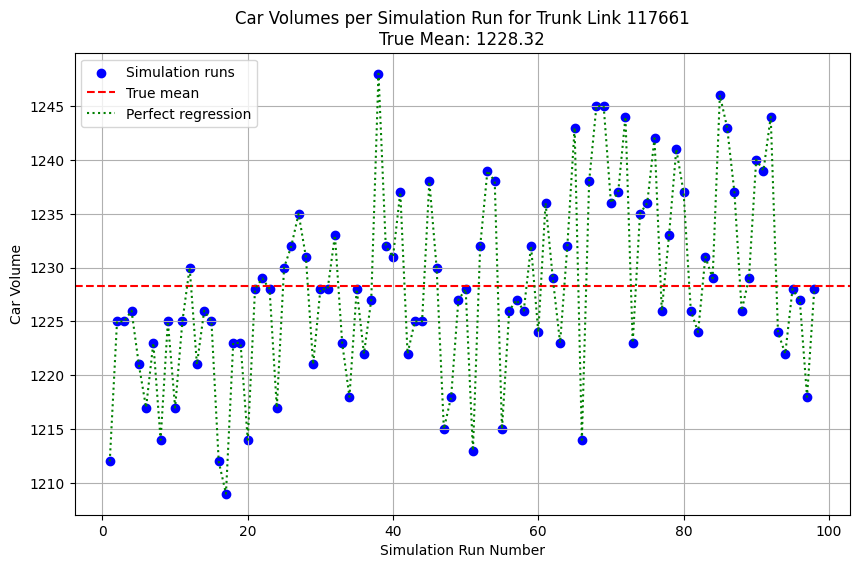

True mean: 1228.32
Number of simulation runs: 98
Standard deviation: 8.65


In [66]:
# Get one trunk link
trunk_link = gdf_basecase_mean[gdf_basecase_mean['highway'] == 'trunk']['link'].iloc[0]

# Get the true mean volume from gdf_basecase_mean
true_mean = gdf_basecase_mean[gdf_basecase_mean['link'] == trunk_link]['vol_car'].iloc[0]

# Get all simulated volumes for this link from different runs
simulated_volumes = []
for df in basecase_output_links_gdfs:
    if trunk_link in df['link'].values:
        volume = df[df['link'] == trunk_link]['vol_car'].iloc[0]
        simulated_volumes.append(volume)

# Create x-axis (simulation run numbers)
run_numbers = range(1, len(simulated_volumes) + 1)

# Create plot
plt.figure(figsize=(10, 6))

# Plot simulated volumes
plt.scatter(run_numbers, simulated_volumes, color='blue', label='Simulation runs')

# Plot mean line
plt.axhline(y=true_mean, color='r', linestyle='--', label='True mean')

# Plot "perfect" regression line (y=x scaled to our data range)
# This would represent perfect correlation between runs
plt.plot(run_numbers, simulated_volumes, color='green', linestyle=':', label='Perfect regression')

plt.xlabel('Simulation Run Number')
plt.ylabel('Car Volume')
plt.title(f'Car Volumes per Simulation Run for Trunk Link {trunk_link}\nTrue Mean: {true_mean:.2f}')
plt.legend()
plt.grid(True)
plt.show()

# Print some statistics
print(f"True mean: {true_mean:.2f}")
print(f"Number of simulation runs: {len(simulated_volumes)}")
print(f"Standard deviation: {np.std(simulated_volumes):.2f}")